In [1]:
%matplotlib inline

from skimage import io, util, segmentation
import numpy as np
import os
import sys
import math
import timeit
import matplotlib.pyplot as plt

In [2]:
def get_k_centers(k, height, width):
    grid_y, grid_x = np.mgrid[:height, :width]
    slices = util.regular_grid((height, width), k)
    step_y, step_x = [s.step if s.step is not None else 1 for s in slices]
    centers_y = grid_y[slices]
    centers_x = grid_x[slices]
    
    centers = np.concatenate([centers_y[..., np.newaxis], centers_x[..., np.newaxis]], axis=-1)
    centers = centers.reshape(-1, 2)
    
    return centers, step_y, step_x

In [3]:
def get_window_bounds(center, step_y, step_x, height, width):
    y_min = int(max(center[0] - step_y, 0))
    y_max = int(min(center[0] + step_y + 1, height))
    x_min = int(max(center[1] - step_x, 0))
    x_max = int(min(center[1] + step_x + 1, width))
    return y_min, y_max, x_min, x_max

In [4]:
def generate_features_vec(points, generate_feature, image):
    feature_vec = []
    for point in points:
        feature_vec.append(generate_feature(point, image))
    return np.asarray(feature_vec)    

In [5]:
def generate_feature(point, image):
    color = np.zeros((image.shape[2],))
    feature = np.concatenate([color, point], axis=-1)
    for i in xrange(image.shape[2]):
        feature[i] = image[feature[-2], feature[-1]][i]
    return feature

In [6]:
def get_yx(feat):
    return feat[-2:]

In [7]:
def calculate_distance(vector, center, weight, step):
    ds = math.sqrt((center[3] - vector[3]) ** 2 + (center[4] - vector[4]) ** 2)
    dc = math.sqrt((center[0] - vector[0]) ** 2 + (center[1] - vector[1]) ** 2 + (center[2] - vector[2]) ** 2)
    d = math.sqrt((dc ** 2) + ((ds/step) ** 2)*(weight**2))
    return d

In [52]:
def slic(image, k, max_iter, weight, generate_feature, calculate_distance, get_yx):
    height, width = image.shape[:2]
    centers_yx, step_y, step_x = get_k_centers(k, height, width)
    
    n_centers = centers_yx.shape[0]
    print 'centers', n_centers
    print centers_yx, step_y, step_x
    step = max(step_y, step_x)
    
    distance_start = np.empty((height, width), dtype=np.double)
    distance_end = np.empty((height, width), dtype=np.double)
    nearest_centers = np.empty((height, width), dtype=np.intp)
    distance = np.empty((height, width), dtype=np.double)
    n_segment_elems = np.zeros(n_centers, dtype=np.intp)

    c_feat_all = generate_features_vec(centers_yx, generate_feature, image)

    for i in xrange(max_iter):
        change = 0
        distance[:, :] = sys.float_info.max
        for k in xrange(n_centers):
            c_feat = c_feat_all[k]
            c = get_yx(c_feat)
            y_min, y_max, x_min, x_max = get_window_bounds(c, step_y, step_x, height, width)
            for y in xrange(y_min, y_max):
                for x in xrange(x_min, x_max):
                    yx_feat = generate_feature((y, x), image)
                    dist = calculate_distance(yx_feat, c_feat, weight, step)
                    if dist < distance[y, x]:
                        nearest_centers[y, x] = k
                        distance[y, x] = dist
                        change = 1

        if i == 0:
            distance_start = np.copy(distance)
        elif i == max_iter-1:
            distance_end = np.copy(distance)
            break

        if change == 0:
            break

        n_segment_elems[:] = 0
        c_feat_all[:, :] = 0
        for y in xrange(height):
            for x in xrange(width):
                k = nearest_centers[y, x]
                n_segment_elems[k] += 1
                yx_feat = generate_feature((y, x), image)
                c_feat_all[k] += yx_feat

        for k in xrange(n_centers):
            c_feat_all[k] /= n_segment_elems[k]

    return nearest_centers, distance_start, distance_end

In [53]:
# params
images = ['Images/Q3/castle2.jpg']
k = 4 # k
max_iter = 10
weight = 100

In [54]:
image = io.imread(images[0])
# image = color.rgb2lab(image)

In [55]:
%time nearest_centers, distance_start, distance_end = slic(image, k, max_iter, weight, generate_feature, calculate_distance, get_yx)

centers 6
[[ 74  74]
 [ 74 224]
 [ 74 374]
 [224  74]
 [224 224]
 [224 374]] 150 150
CPU times: user 1min 14s, sys: 668 ms, total: 1min 14s
Wall time: 1min 16s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
# image2 = color.lab2rgb(image)
marks = segmentation.mark_boundaries(image, nearest_centers)

min_dist = min(np.min(distance_start), np.min(distance_end))
max_dist = min(np.max(distance_start), np.max(distance_end))

print min_dist, max_dist

0.0 186.733275321


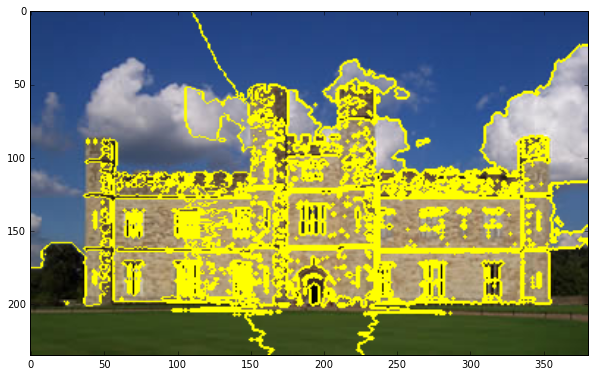

In [41]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(marks)

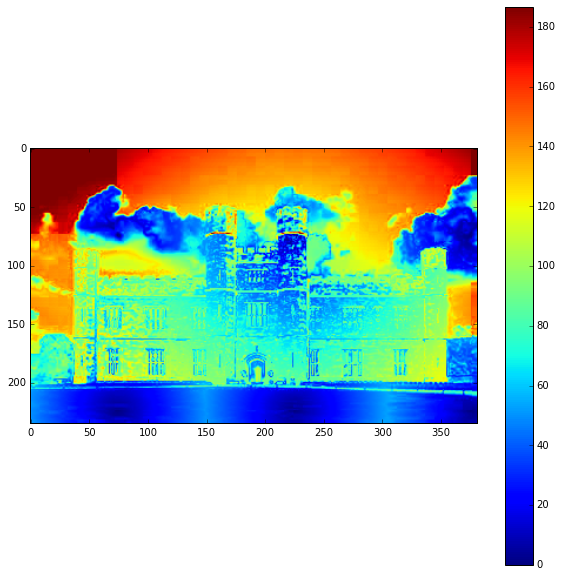

In [42]:
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
heatmap = ax2.imshow(distance_start, vmin=min_dist, vmax=max_dist)
fig2.colorbar(heatmap);

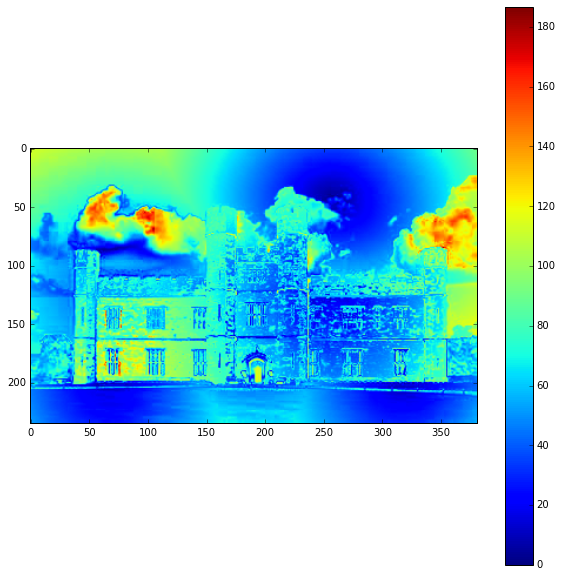

In [43]:
fig3, ax3 = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
heatmap2 = ax3.imshow(distance_end, vmin=min_dist, vmax=max_dist)
fig3.colorbar(heatmap2);